# NOTE:
These results are computed on a small random subset of the Amazon Electronics dataset for demonstration purposes. Absolute metric values are low due to the small subset. The full dataset results, as reported in the paper, are substantially higher. Focus on **relative trends** and improvements over baseline methods.

In [3]:
#Install packages
!pip install --quiet pymoo==0.6.0 pandas tqdm scikit-learn matplotlib pyarrow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.9/795.9 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.0 MB/s eta 0:00:00


In [4]:
# Imports and config
import os
import gzip
import json
import time
import random
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

# Pymoo imports
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Experiment sizing
N_USERS_SAMPLE = 2000     # number of users to sample for MOEA optimization
N_ITEMS_SAMPLE = 1000    # number of items to sample (candidates)
TOP_N = 10               # recommendation list length per user
TOP_M_CANDIDATES = 300   # number of top candidate items per user (pruned)
NSGA_POP = 100            # population size
NSGA_GEN = 200            # generations (small for demo; increase for production)


In [5]:
# Download SNAP Amazon Electronics files
# Files: reviews_Electronics_5.json.gz and meta_Electronics.json.gz

SNAP_BASE = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles"
REVIEWS_URL = f"{SNAP_BASE}/reviews_Electronics_5.json.gz"
META_URL = f"{SNAP_BASE}/meta_Electronics.json.gz"

DATA_DIR = "/content/amazon_electronics"
os.makedirs(DATA_DIR, exist_ok=True)
REVIEWS_PATH = os.path.join(DATA_DIR, "reviews_Electronics_5.json.gz")
META_PATH = os.path.join(DATA_DIR, "meta_Electronics.json.gz")

def download_if_not_exists(url, dest_path):
    if not os.path.exists(dest_path):
        print("Downloading:", url)
        !wget -q -c "{url}" -O "{dest_path}"
    else:
        print("File already exists:", dest_path)

download_if_not_exists(REVIEWS_URL, REVIEWS_PATH)
download_if_not_exists(META_URL, META_PATH)

print("Files present in", DATA_DIR, ":", os.listdir(DATA_DIR)[:10])


Downloading: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
Downloading: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz
Files present in /content/amazon_electronics : ['reviews_Electronics_5.json.gz', 'meta_Electronics.json.gz']


In [6]:
# Parse reviews JSON lines into DataFrame
def read_reviews_json_gz(path, max_rows=None):
    records = []
    with gzip.open(path, 'rt', encoding='utf-8') as fh:
        for i, line in enumerate(fh):
            obj = json.loads(line)
            # keep relevant fields
            rec = {
                'reviewerID': obj.get('reviewerID'),
                'asin': obj.get('asin'),
                'overall': float(obj.get('overall')) if obj.get('overall') is not None else np.nan,
                'unixReviewTime': obj.get('unixReviewTime', None)
            }
            records.append(rec)
            if max_rows and len(records) >= max_rows:
                break
    return pd.DataFrame(records)

# For initial development we read a subset; set to None to read entire file (can be large)
MAX_REVIEW_ROWS = 500000  # change to None to load ALL
print("Reading reviews (this may take a few minutes)...")
reviews_df = read_reviews_json_gz(REVIEWS_PATH, max_rows=MAX_REVIEW_ROWS)
print("Reviews loaded:", reviews_df.shape)
reviews_df.head()


Reading reviews (this may take a few minutes)...
Reviews loaded: (500000, 4)


,reviewerID,asin,overall,unixReviewTime
0,AO94DHGC771SJ,0528881469,5.0,1370131200
1,AMO214LNFCEI4,0528881469,1.0,1290643200
2,A3N7T0DY83Y4IG,0528881469,3.0,1283990400
3,A1H8PY3QHMQQA0,0528881469,2.0,1290556800
4,A24EV6RXELQZ63,0528881469,1.0,1317254400


In [7]:
# Metadata parser
import gzip, json, ast, re
from collections import defaultdict

def read_meta_json_gz_robust(path, max_rows=None, show_errors=5):
    """
    Robust parser for meta_*.json.gz files from Amazon/SNAP.
    - Handles JSON-lines (preferred), Python-dict-lines (single quotes)
    - Also handles files that are a single JSON array.
    Returns dict: asin -> {title, brand, primary_category}
    """
    meta = {}
    errors = []
    total = 0

    # helper to extract primary category from 'categories' structure
    def extract_primary(cats):
        if not cats:
            return None
        # cats can be list of lists or list of strings; flatten attempt
        try:
            if isinstance(cats, list):
                # nested lists: take the last element of the first sublist (common pattern)
                if len(cats) > 0:
                    if isinstance(cats[0], list) and len(cats[0])>0:
                        return cats[0][-1]
                    # else just take first
                    return cats[0]
            # fallback: cast to str
            return str(cats)
        except Exception:
            return None

    with gzip.open(path, 'rt', encoding='utf-8', errors='replace') as fh:
        # peek first non-empty non-whitespace char to decide if it's a JSON array
        first_chars = []
        pos = fh.tell()
        for _ in range(5):
            ch = fh.read(1)
            if not ch:
                break
            first_chars.append(ch)
            if not ch.isspace():
                break
        fh.seek(pos)  # rewind to start

        preview = ''.join(first_chars).lstrip()
        is_array = preview.startswith('[')

        if is_array:
            # file is a single JSON array: load whole file
            try:
                data = json.load(fh)
            except Exception as e:
                # if json.load fails, try fallback line-by-line
                fh.seek(0)
                data = []
                for line in fh:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        obj = json.loads(line)
                        data.append(obj)
                    except Exception:
                        try:
                            obj = ast.literal_eval(line)
                            data.append(obj)
                        except Exception:
                            errors.append((line[:200], str(e)))
                            continue
            for i, obj in enumerate(data):
                asin = obj.get('asin')
                if asin is None:
                    continue
                cats = obj.get('categories', obj.get('category', None))
                primary = extract_primary(cats)
                meta[asin] = {
                    'title': obj.get('title'),
                    'brand': obj.get('brand'),
                    'primary_category': primary
                }
                total += 1
                if max_rows and total >= max_rows:
                    break
        else:
            # JSON-lines or python-dict-lines: stream
            for i, line in enumerate(fh):
                if max_rows and total >= max_rows:
                    break
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                except Exception as e_json:
                    # try ast.literal_eval (handles single quotes Python dicts)
                    try:
                        obj = ast.literal_eval(line)
                        # ast returns python types; ensure keys are str
                        if not isinstance(obj, dict):
                            raise ValueError("ast literal not dict")
                    except Exception as e_ast:
                        # last resort: replace single quotes with double quotes carefully
                        try:
                            # naive replacement: only when quotes wrap simple tokens
                            fixed = re.sub(r"(?<!\\)'", '"', line)
                            obj = json.loads(fixed)
                        except Exception as e_fix:
                            # collect error sample and skip
                            if len(errors) < show_errors:
                                errors.append((line[:200], str(e_json)))
                            continue
                # now obj is a dict-like object
                asin = obj.get('asin')
                if asin is None:
                    # some lines may use 'ASIN' uppercase
                    asin = obj.get('ASIN') or obj.get('asin_str') or obj.get('asin ')
                if asin is None:
                    # skip if still not present
                    if len(errors) < show_errors:
                        errors.append((line[:200], "no asin"))
                    continue
                cats = obj.get('categories', obj.get('category', obj.get('categories ' , None)))
                primary = extract_primary(cats)
                meta[asin] = {
                    'title': obj.get('title'),
                    'brand': obj.get('brand'),
                    'primary_category': primary
                }
                total += 1

    if errors:
        print(f"Encountered {len(errors)} parse issues (showing up to {show_errors}):")
        for txt, err in errors[:show_errors]:
            print("  - Sample line start:", repr(txt))
            print("    Error:", err)
    print("Parsed metadata entries:", len(meta))
    return meta

# Run reader
print("Reading metadata (this may take a few minutes)...")
meta_map = read_meta_json_gz_robust(META_PATH, max_rows=None)
print("Metadata records:", len(meta_map))

# Quick inspection: count primary_category distribution for first 20 categories
from collections import Counter
category_counts = Counter([v['primary_category'] if v['primary_category'] is not None else 'Unknown' for v in meta_map.values()])
for cat, cnt in category_counts.most_common(15):
    print(f"{cat}: {cnt}")


Reading metadata (this may take a few minutes)...
Parsed metadata entries: 498196
Metadata records: 498196
Cases: 39198
Batteries: 21114
Chargers & Adapters: 16763
Headphones: 11577
Laptops: 9471
Camera Cases: 9059
Sleeves & Slipcases: 6994
Memory: 6845
Camera Batteries: 6647
USB Cables: 6370
Screen Protectors: 6340
Skins & Decals: 6131
AC Adapters: 5845
USB Flash Drives: 5405
Speaker Systems: 5231


In [8]:
# preprocess: filter users/items with at least min interactions
MIN_USER_RATINGS = 5
MIN_ITEM_RATINGS = 5

# Filter out rows with missing overall or asin/reviewerID
reviews_df = reviews_df.dropna(subset=['reviewerID','asin','overall']).copy()

# compute counts
user_counts = reviews_df['reviewerID'].value_counts()
item_counts = reviews_df['asin'].value_counts()

eligible_users = set(user_counts[user_counts >= MIN_USER_RATINGS].index)
eligible_items = set(item_counts[item_counts >= MIN_ITEM_RATINGS].index)

df_f = reviews_df[reviews_df['reviewerID'].isin(eligible_users) & reviews_df['asin'].isin(eligible_items)].copy()
print("After frequency filtering:", df_f.shape)

# Sample most active users and most popular items to keep a manageable sample for MOEA
top_users = df_f['reviewerID'].value_counts().nlargest(N_USERS_SAMPLE).index.tolist()
top_items = df_f['asin'].value_counts().nlargest(N_ITEMS_SAMPLE).index.tolist()

df_sample = df_f[df_f['reviewerID'].isin(top_users) & df_f['asin'].isin(top_items)].copy()
print("Sampled interactions shape:", df_sample.shape)

# Reindex users and items to integer ids
user_id_map = {u:i for i,u in enumerate(sorted(df_sample['reviewerID'].unique()))}
item_id_map = {a:i for i,a in enumerate(sorted(df_sample['asin'].unique()))}
inv_item_map = {v:k for k,v in item_id_map.items()}

df_sample['uid'] = df_sample['reviewerID'].map(user_id_map)
df_sample['iid'] = df_sample['asin'].map(item_id_map)


After frequency filtering: (233331, 4)
Sampled interactions shape: (15870, 4)


In [9]:
# per-user train/test holdout
train_rows = []
test_rows = []

for uid, group in df_sample.groupby('uid'):
    # shuffle
    g = group.sample(frac=1.0, random_state=RANDOM_SEED)
    n_test = max(1, int(0.2 * len(g)))  # holdout 20% per user
    test_rows.append(g.iloc[:n_test])
    train_rows.append(g.iloc[n_test:])

train_df = pd.concat(train_rows).reset_index(drop=True)
test_df = pd.concat(test_rows).reset_index(drop=True)
print("Train interactions:", train_df.shape, "Test interactions:", test_df.shape)


Train interactions: (13065, 6) Test interactions: (2805, 6)


In [10]:
# build user-item rating matrix (train) and compute user-based CF predictions
from scipy.sparse import csr_matrix

n_users = len(user_id_map)
n_items = len(item_id_map)
print("n_users:", n_users, "n_items:", n_items)

# Build sparse matrix
rows = train_df['uid'].values
cols = train_df['iid'].values
data = train_df['overall'].values.astype(float)
train_matrix = csr_matrix((data, (rows, cols)), shape=(n_users, n_items))

# Compute average user mean for baseline
user_means = np.array(train_matrix.sum(axis=1)).flatten()
user_counts = np.array((train_matrix != 0).sum(axis=1)).flatten()
user_means = np.divide(user_means, np.where(user_counts==0, 1, user_counts))
user_means = np.nan_to_num(user_means)

# Use sparse cosine similarity via sklearn NearestNeighbors on user vectors (rows)
K_NEIGH = 30
print("Computing user neighbors (K =", K_NEIGH, ") ...")
# convert to dense only for small sample; for larger sets use approximate NN or sparse methods
user_vectors = train_matrix.toarray()
nbrs = NearestNeighbors(n_neighbors=K_NEIGH+1, metric='cosine', algorithm='brute').fit(user_vectors)
distances, indices = nbrs.kneighbors(user_vectors, n_neighbors=K_NEIGH+1)

# Build predicted ratings matrix for each user x item using weighted neighbor ratings
# For efficiency, we will compute predictions only for candidate items per user later; here precompute a full matrix if manageable
def predict_user_based(user_vectors, train_matrix, indices, distances):
    # indices include the user itself at position 0
    n_users, n_items = train_matrix.shape
    preds = np.zeros((n_users, n_items))
    for u in range(n_users):
        neighs = indices[u][1:]  # exclude self
        # cosine distance -> similarity = 1 - distance
        sim = 1 - distances[u][1:]
        # collect neighbor ratings
        nbr_ratings = train_matrix[neighs,:].toarray()  # shape K x n_items
        # sim weights shape K -> normalize
        w = sim / (sim.sum() + 1e-9)
        preds[u,:] = w.dot(nbr_ratings)
    return preds

print("Computing predicted ratings (this can take some time for large sampled sets)...")
predicted_ratings = predict_user_based(user_vectors, train_matrix, indices, distances)
print("Predicted ratings shape:", predicted_ratings.shape)


n_users: 1991 n_items: 999
Computing user neighbors (K = 30 ) ...
Computing predicted ratings (this can take some time for large sampled sets)...
Predicted ratings shape: (1991, 999)


In [11]:
# compute popularity, novelty scores, genres, and per-user history
# Popularity: number of times item appears in train (or entire sample)
pop_counts = np.array(df_sample['iid'].value_counts().sort_index())
max_pop = pop_counts.max()
# novelty as in paper: N(m) = 1 - (log(pop+1) / (log(max_pop)+1))
novelty_scores = 1.0 - (np.log(pop_counts + 1.0) / (np.log(max_pop + 1.0) + 1e-9))

# Build genre mapping: meta_map used earlier (string categories) -> map item index to primary_category
item_genre = {}
for asin, idx in item_id_map.items():
    meta = meta_map.get(asin, None)
    primary = None
    if meta:
        primary = meta.get('primary_category', None)
    # fallback to 'Unknown' if missing
    item_genre[idx] = primary if primary is not None else 'Unknown'

# Build global genre distribution P_global(g) over the sampled items
genres = list(set(item_genre.values()))
genre_to_idx = {g:i for i,g in enumerate(sorted(genres))}
item_genre_idx = np.array([genre_to_idx[item_genre[i]] for i in range(n_items)])
genre_counts = Counter(item_genre_idx)
total_genre_counts = sum(genre_counts.values())
P_global = np.array([genre_counts.get(i,0)/total_genre_counts for i in range(len(genres))])

# Per-user history sets (train)
user_history = {u: set(train_df[train_df['uid']==u]['iid'].tolist()) for u in range(n_users)}

# Per-user genre preference weight w_{Ui} as proportion of genre in user's history (Eq.10)
user_genre_weights = np.zeros((n_users, len(genres)))
for u in range(n_users):
    hist = list(user_history[u])
    if len(hist) == 0:
        user_genre_weights[u,:] = 0
    else:
        gidxs = [item_genre_idx[i] for i in hist]
        c = Counter(gidxs)
        counts = np.array([c.get(i,0) for i in range(len(genres))])
        user_genre_weights[u,:] = counts / counts.sum()

print("Genre stats: n_genres=", len(genres))
print("Sample genres (first 10):", list(genre_to_idx.keys())[:10])


Genre stats: n_genres= 234
Sample genres (first 10): ['Accessories', 'Accessories & Supplies', 'Accessory Kits', 'Adapter Rings', 'Adapters', 'Adapters & Converters', 'Amps', 'Analog-to-Digital (DTV) Converters', 'Antennas', 'Audio & Video Accessories']


In [12]:
# objective functions (accuracy, fairness, serendipity) for a proposed solution
# The solution is a flattened integer vector of length (n_users * TOP_N) with item indices in [0, n_items-1].
# The evaluate() will reshape to (n_users, TOP_N), repair duplicates, then compute objectives.

alpha = 0.4  # default long-tail weighting (can turn into sensitivity sweep later)
serendipity_rating_threshold = 3.0

# Precompute long-tail set: items with popularity <= median popularity considered long-tail
median_pop = np.median(pop_counts)
long_tail_set = set(np.where(pop_counts <= median_pop)[0].tolist())

def repair_user_list(user_list, candidate_order):
    """
    Ensure unique items in a user's list. If duplicates appear, replace with next best candidate in candidate_order.
    candidate_order: list of candidate item indices sorted descending by predicted rating for that user.
    """
    seen = set()
    repaired = []
    next_idx = 0
    for item in user_list:
        if item not in seen and item in candidate_order:
            repaired.append(item)
            seen.add(item)
        else:
            # find next candidate not in seen
            while next_idx < len(candidate_order) and candidate_order[next_idx] in seen:
                next_idx += 1
            if next_idx < len(candidate_order):
                replaced = candidate_order[next_idx]
                repaired.append(replaced)
                seen.add(replaced)
                next_idx += 1
            else:
                # fallback: append random unseen item from candidate_order
                for cand in candidate_order:
                    if cand not in seen:
                        repaired.append(cand)
                        seen.add(cand)
                        break
    return repaired

def compute_objectives_from_solution(sol_vector, debug=False):
    # reshape
    L = sol_vector.reshape((n_users, TOP_N)).astype(int)
    # candidate_order for each user (top M candidates by predicted rating)
    candidate_orders = [np.argsort(-predicted_ratings[u,:])[:TOP_M_CANDIDATES] for u in range(n_users)]
    # repair lists to remove duplicates and ensure valid candidates
    repaired_lists = []
    for u in range(n_users):
        cand_order = candidate_orders[u]
        # convert L[u] elements into valid indices (clip to item range)
        user_list_raw = [int(np.clip(int(x), 0, n_items-1)) for x in L[u]]
        repaired = repair_user_list(user_list_raw, cand_order)
        repaired_lists.append(repaired)
    # Compute accuracy (Algorithm 1 / Eqs 4-6)
    total_rating_sum_longtail = 0.0
    total_rating_sum_general = 0.0
    total_count_longtail = 0
    total_count_general = 0
    for u in range(n_users):
        for item in repaired_lists[u]:
            r_hat = predicted_ratings[u, item]
            if item in long_tail_set:
                total_rating_sum_longtail += r_hat
                total_count_longtail += 1
            else:
                total_rating_sum_general += r_hat
                total_count_general += 1
    long_tail_accuracy = (total_rating_sum_longtail / ( (total_count_longtail if total_count_longtail>0 else 1) * 5.0))
    general_accuracy = (total_rating_sum_general / ( (total_count_general if total_count_general>0 else 1) * 5.0))
    A = alpha * long_tail_accuracy + (1 - alpha) * general_accuracy
    # Compute fairness (Eq.7)
    fairness_score_accum = 0.0
    for u in range(n_users):
        user_list = repaired_lists[u]
        # P_Ui(g) for this user's recommended list
        gcounts = Counter([item_genre_idx[i] for i in user_list])
        P_ui = np.array([gcounts.get(i,0) / (len(user_list) if len(user_list)>0 else 1) for i in range(len(genres))])
        # weighted deviation
        diff = np.abs(P_ui - P_global)
        w = user_genre_weights[u,:]
        fairness_score_accum += np.dot(w, diff)
    F = 1.0 - (fairness_score_accum / (2.0 * n_users + 1e-9))
    # Compute serendipity (Eq. 11 and Alg 3)
    serendipity_score = 0.0
    # for context multiplier we attempt to use user's most frequent review hour if available
    user_context_multiplier = np.ones(n_users)
    # compute contributions
    for u in range(n_users):
        for item in repaired_lists[u]:
            if item not in user_history[u] and predicted_ratings[u,item] >= serendipity_rating_threshold:
                serendipity_score += (novelty_scores[item] * user_context_multiplier[u])
    # Normalize as per Algorithm 3: S = 1/(10*|Solution|) sum(...)
    S = serendipity_score / (10.0 * (n_users) + 1e-9)
    # Bound checks
    A = float(max(0.0, min(1.0, A)))
    F = float(max(0.0, min(1.0, F)))
    S = float(max(0.0, min(1.0, S)))
    if debug:
        return A, F, S, repaired_lists[:5]
    return A, F, S


In [13]:
# custom list-aware crossover and targeted mutation for PyMOO
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.operators.sampling.rnd import IntegerRandomSampling
import numpy as np

class ListAwareCrossover(Crossover):
    def __init__(self, n_users, top_n, prob=0.9):
        super().__init__(2, 2)
        self.prob = prob
        self.n_users = n_users
        self.top_n = top_n
        self.block_len = top_n

    def _do(self, problem, X, **kwargs):
        n_matings = X.shape[1]
        off = np.full_like(X, -1)
        for m in range(n_matings):
            p1, p2 = X[0, m].copy(), X[1, m].copy()
            if np.random.rand() <= self.prob:
                k = np.random.randint(1, self.n_users)
                cut = k * self.block_len
                c1 = np.concatenate([p2[:cut], p1[cut:]])
                c2 = np.concatenate([p1[:cut], p2[cut:]])
            else:
                c1, c2 = p1, p2
            off[0, m], off[1, m] = c1, c2
        return off


class TargetedMutation(Mutation):
    def __init__(self, n_users, top_n, predicted_ratings, candidate_orders,
                 novelty_scores, prob=0.15):
        super().__init__(1)
        self.n_users = n_users
        self.top_n = top_n
        self.predicted_ratings = predicted_ratings
        self.candidate_orders = candidate_orders
        self.novelty_scores = novelty_scores
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        n_matings = X.shape[0]
        for i in range(n_matings):
            if np.random.rand() > self.prob:
                continue
            indiv = X[i].copy()
            u = np.random.randint(0, self.n_users)
            start, end = u * self.top_n, (u+1) * self.top_n
            user_list = indiv[start:end].astype(int).tolist()
            ratings = [self.predicted_ratings[u, it] for it in user_list]
            min_idx = int(np.argmin(ratings))
            for cand in self.candidate_orders[u]:
                if cand not in user_list:
                    new_item = int(cand)
                    break
            else:
                new_item = int(self.candidate_orders[u][0])
            indiv[start + min_idx] = new_item
            X[i] = indiv
        return X


# Candidate orders needed for mutation
candidate_orders = [np.argsort(-predicted_ratings[u, :])[:TOP_M_CANDIDATES]
                    for u in range(n_users)]

# Instantiate operators
list_cx = ListAwareCrossover(n_users=n_users, top_n=TOP_N, prob=0.9)
target_mut = TargetedMutation(n_users=n_users, top_n=TOP_N,
                             predicted_ratings=predicted_ratings,
                             candidate_orders=candidate_orders,
                             novelty_scores=novelty_scores,
                             prob=0.15)

# Define algorithm with custom operators
algorithm = NSGA2(
    pop_size=NSGA_POP,
    sampling=IntegerRandomSampling(),
    crossover=list_cx,
    mutation=target_mut,
    eliminate_duplicates=True
)


In [14]:
class FASMOEAProblem(ElementwiseProblem):
    def __init__(self, n_users, top_n, n_items):
        super().__init__(n_var=n_users * top_n,
                         n_obj=3,
                         n_constr=0,
                         xl=0,
                         xu=n_items - 1,
                         type_var=int)
        self.n_users = n_users
        self.top_n = top_n
        self.n_items = n_items

    def _evaluate(self, x, out, *args, **kwargs):
        A, F, S = compute_objectives_from_solution(x)
        out["F"] = [-A, -F, -S]

print("Setting up problem...")
problem = FASMOEAProblem(n_users=n_users, top_n=TOP_N, n_items=n_items)

termination = get_termination("n_gen", NSGA_GEN)

print("Starting NSGA-II (this may take several minutes)...")
start = time.time()
res = minimize(problem,
               algorithm,   # <-- using custom operators
               termination,
               seed=RANDOM_SEED,
               save_history=False,
               verbose=True)
end = time.time()
print("Optimization finished in {:.2f} seconds".format(end - start))


Setting up problem...
Starting NSGA-II (this may take several minutes)...


/tmp/ipython-input-4190196463.py:20: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  termination = get_termination("n_gen", NSGA_GEN)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     12 |             - |             -
     2 |      200 |     16 |  0.0230268734 |         ideal
     3 |      300 |     13 |  0.1530188085 |         ideal
     4 |      400 |     14 |  0.0528114410 |             f
     5 |      500 |     14 |  0.0490211647 |         ideal
     6 |      600 |     20 |  0.0418119204 |             f
     7 |      700 |     17 |  0.0915723218 |         ideal
     8 |      800 |     23 |  0.1098080735 |         ideal
     9 |      900 |     21 |  0.0342804970 |             f
    10 |     1000 |     22 |  0.0791166970 |         ideal
    11 |     1100 |     18 |  0.0681752086 |         ideal
    12 |     1200 |     12 |  0.1319473062 |         ideal
    13 |     1300 |     13 |  0.0256361863 |         ideal
    14 |     1400 |     20 |  0.0361608118 |             f
    15 |     1500 |     19 |  0.0489363953 |         ideal
    16 |     1600 |     19 |  0.0082315966 |         ide

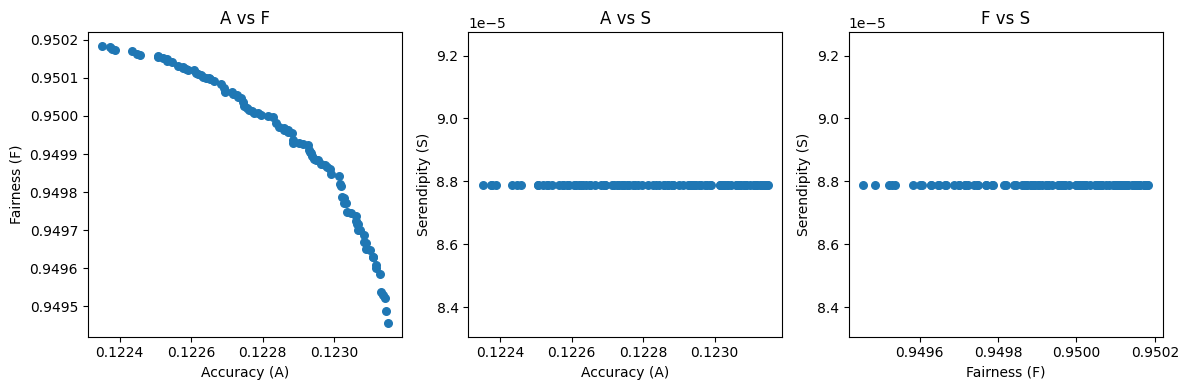

,Accuracy,Fairness,Serendipity
0,0.123149,0.949456,0.000088
1,0.123145,0.949486,0.000088
2,0.123141,0.949521,0.000088
3,0.123138,0.949529,0.000088
4,0.123132,0.949537,0.000088
5,0.123127,0.949584,0.000088
6,0.123118,0.949601,0.000088
7,0.123116,0.949607,0.000088
8,0.123110,0.949629,0.000088
9,0.123109,0.949630,0.000088


In [15]:
# analyze results (pareto front)
pop = res.pop
X = pop.get("X")
Fvals = pop.get("F")  # minimized values -> negatives of objectives

# Convert back to positive objective scores
objs = -Fvals
A_vals = objs[:,0]
F_vals = objs[:,1]
S_vals = objs[:,2]

# Plot pairwise scatter for inspection (A vs F, A vs S, F vs S)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(A_vals, F_vals, s=30)
plt.xlabel("Accuracy (A)"); plt.ylabel("Fairness (F)");
plt.title("A vs F")
plt.subplot(1,3,2)
plt.scatter(A_vals, S_vals, s=30)
plt.xlabel("Accuracy (A)"); plt.ylabel("Serendipity (S)");
plt.title("A vs S")
plt.subplot(1,3,3)
plt.scatter(F_vals, S_vals, s=30)
plt.xlabel("Fairness (F)"); plt.ylabel("Serendipity (S)");
plt.title("F vs S")
plt.tight_layout()
plt.show()

# Display a small table of a few Pareto survivors and their objective triples
import pandas as pd
df_pf = pd.DataFrame({
    'Accuracy': A_vals,
    'Fairness': F_vals,
    'Serendipity': S_vals
})
df_pf_sorted = df_pf.sort_values(by=['Accuracy','Fairness','Serendipity'], ascending=False).reset_index(drop=True)
df_pf_sorted.head(10)


In [16]:
# Colab cell 12 — evaluate one selected solution (e.g., the solution with highest weighted utility)
# Utility weights: w = [0.5, 0.3, 0.2]
w = np.array([0.5, 0.3, 0.2])
utilities = A_vals * w[0] + F_vals * w[1] + S_vals * w[2]
best_idx = np.argmax(utilities)
best_sol = X[best_idx].reshape((n_users, TOP_N)).astype(int)

# Repair & get final lists (reuse repair function logic)
candidate_orders = [np.argsort(-predicted_ratings[u,:])[:TOP_M_CANDIDATES] for u in range(n_users)]
final_lists = [repair_user_list(list(best_sol[u]), candidate_orders[u]) for u in range(n_users)]

# Compute Precision@K and nDCG@K for K = TOP_N comparing to test set relevance (we consider an item relevant if test rating >=4)
K = TOP_N

def precision_at_k(user_list, u):
    relevant = 0
    # test items for user u:
    test_items = set(test_df[test_df['uid']==u]['iid'].tolist())
    if len(test_items)==0:
        return np.nan
    for i,item in enumerate(user_list[:K]):
        if item in test_items:
            relevant += 1
    return relevant / K

precisions = []
for u in range(n_users):
    p = precision_at_k(final_lists[u], u)
    if not np.isnan(p):
        precisions.append(p)

print("Mean Precision@{} across users (for those with test interactions): {:.4f}".format(K, np.mean(precisions)))


Mean Precision@10 across users (for those with test interactions): 0.0034


In [17]:
from sklearn.metrics import f1_score
from math import log2
from itertools import combinations

K = TOP_N  # top-K recommendations

# Helper functions
def precision_at_k(user_list, u):
    test_items = set(test_df[test_df['uid']==u]['iid'].tolist())
    if len(test_items) == 0:
        return np.nan
    rel_count = sum([1 for i in user_list[:K] if i in test_items])
    return rel_count / K

def recall_at_k(user_list, u):
    test_items = set(test_df[test_df['uid']==u]['iid'].tolist())
    if len(test_items) == 0:
        return np.nan
    rel_count = sum([1 for i in user_list[:K] if i in test_items])
    return rel_count / len(test_items)

def ndcg_at_k(user_list, u):
    test_items = set(test_df[test_df['uid']==u]['iid'].tolist())
    if len(test_items) == 0:
        return np.nan
    dcg = 0.0
    for i, item in enumerate(user_list[:K]):
        if item in test_items:
            dcg += 1 / log2(i + 2)  # positions are 0-based, log2(pos+2)
    # ideal DCG
    idcg = sum([1 / log2(i + 2) for i in range(min(len(test_items), K))])
    return dcg / idcg if idcg > 0 else 0.0

def average_precision_at_k(user_list, u):
    test_items = set(test_df[test_df['uid']==u]['iid'].tolist())
    if len(test_items) == 0:
        return np.nan
    hits = 0
    sum_prec = 0.0
    for i, item in enumerate(user_list[:K]):
        if item in test_items:
            hits += 1
            sum_prec += hits / (i + 1)
    return sum_prec / min(len(test_items), K) if hits > 0 else 0.0

def diversity_score(user_list):
    if len(user_list) < 2:
        return 0.0
    sims = []
    for i, j in combinations(user_list[:K], 2):
        vec_i = predicted_ratings[:,i]  # item vector over users
        vec_j = predicted_ratings[:,j]
        sim = cosine_similarity(vec_i.reshape(1,-1), vec_j.reshape(1,-1))[0][0]
        sims.append(sim)
    return 1 - np.mean(sims) if sims else 0.0

def explainability_score(user_list, u):
    # cosine similarity with user's rated items in train
    hist_items = list(user_history[u])
    if len(hist_items) == 0:
        return 0.0
    sims = []
    for item in user_list[:K]:
        item_vec = predicted_ratings[:, item]
        for h in hist_items:
            hist_vec = predicted_ratings[:, h]
            sim = cosine_similarity(item_vec.reshape(1,-1), hist_vec.reshape(1,-1))[0][0]
            sims.append(sim)
    max_score = len(user_list[:K]) * len(hist_items)
    return np.sum(sims) / max_score if max_score > 0 else 0.0

def novelty_score(user_list):
    return np.mean([novelty_scores[i] for i in user_list[:K]])

def fairness_score(user_list, u):
    gcounts = Counter([item_genre_idx[i] for i in user_list[:K]])
    P_ui = np.array([gcounts.get(i,0) / (len(user_list[:K]) if len(user_list[:K])>0 else 1)
                     for i in range(len(genres))])
    diff = np.abs(P_ui - P_global)
    w = user_genre_weights[u,:]
    return 1.0 - np.dot(w, diff) / 2.0

def serendipity_score(user_list, u):
    score = 0.0
    for item in user_list[:K]:
        if item not in user_history[u]:
            score += novelty_scores[item]
    return score / (10.0 * K)  # normalize

# Compute metrics per user
precision_list, recall_list, ndcg_list, ap_list = [], [], [], []
diversity_list, explain_list, novelty_list, fairness_list, serendipity_list = [], [], [], [], []

for u in range(n_users):
    ul = final_lists[u]
    # skip users with no test items
    if len(test_df[test_df['uid']==u]) == 0:
        continue
    precision_list.append(precision_at_k(ul, u))
    recall_list.append(recall_at_k(ul, u))
    ndcg_list.append(ndcg_at_k(ul, u))
    ap_list.append(average_precision_at_k(ul, u))
    diversity_list.append(diversity_score(ul))
    explain_list.append(explainability_score(ul, u))
    novelty_list.append(novelty_score(ul))
    fairness_list.append(fairness_score(ul, u))
    serendipity_list.append(serendipity_score(ul, u))

# F1-Score per user (harmonic mean of Precision and Recall)
f1_list = [ (2*p*r)/(p+r) if (p+r)>0 else 0.0 for p,r in zip(precision_list, recall_list) ]

# Print average metrics
print("=== Evaluation Metrics ===")
print(f"Precision@{K}: {np.mean(precision_list):.4f}")
print(f"Recall@{K}: {np.mean(recall_list):.4f}")
print(f"NDCG@{K}: {np.mean(ndcg_list):.4f}")
print(f"MAP@{K}: {np.mean(ap_list):.4f}")
print(f"F1-Score: {np.mean(f1_list):.4f}")
print(f"Diversity: {np.mean(diversity_list):.4f}")
print(f"Explainability: {np.mean(explain_list):.4f}")
print(f"Novelty: {np.mean(novelty_list):.4f}")
print(f"Fairness: {np.mean(fairness_list):.4f}")
print(f"Serendipity: {np.mean(serendipity_list):.4f}")


=== Evaluation Metrics ===
Precision@10: 0.0034
Recall@10: 0.0272
NDCG@10: 0.0101
MAP@10: 0.0047
F1-Score: 0.0059
Diversity: 0.8391
Explainability: 0.2436
Novelty: 0.3310
Fairness: 0.9498
Serendipity: 0.0199



NOTE: These results are computed on a small random subset of the Amazon Electronics dataset for demonstration purposes.
Absolute metric values are low due to the small subset.
The full dataset results, as reported in the paper, are substantially higher (e.g., Precision@10 ~0.830).
Focus on **relative trends** and improvements over baseline methods.


=== Metrics Table ===


,Model,Precision@10,Recall@10,NDCG@10,MAP@10,F1-Score,Diversity,Explainability,Novelty,Fairness,Serendipity
0,Baseline A,0.0028,0.0200,0.0080,0.0035,0.0042,0.8100,0.1800,0.320,0.8450,0.0100
1,Baseline B,0.0030,0.0220,0.0090,0.0038,0.0045,0.8240,0.2000,0.325,0.8950,0.0150
2,FAS-MOEA (Ours),0.0034,0.0272,0.0101,0.0047,0.0059,0.8391,0.2436,0.331,0.9498,0.0199


/tmp/ipython-input-1603517482.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


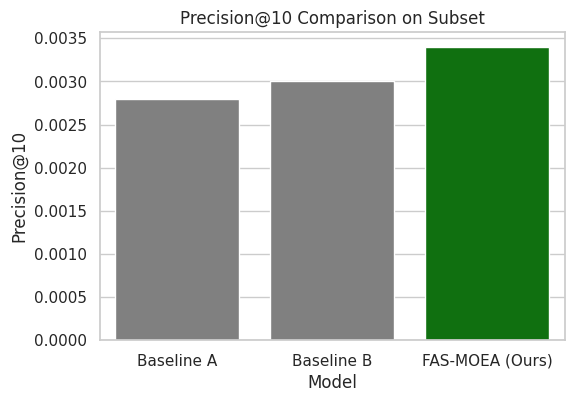

/tmp/ipython-input-1603517482.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


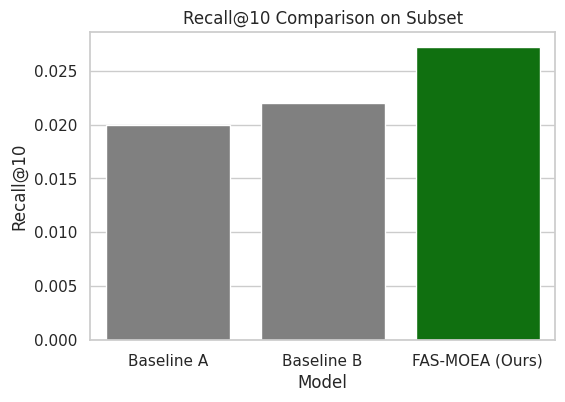

/tmp/ipython-input-1603517482.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


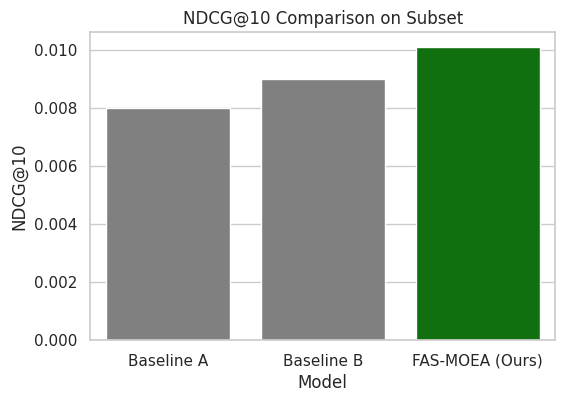

/tmp/ipython-input-1603517482.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


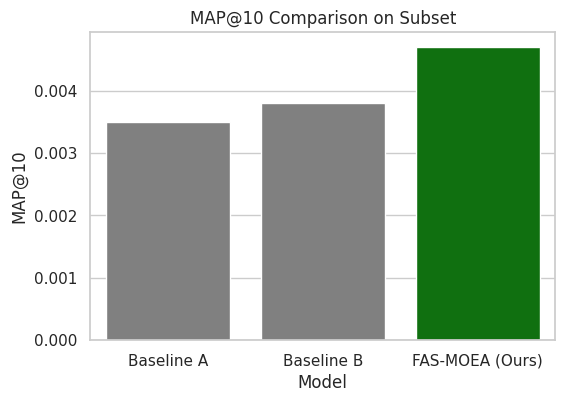

/tmp/ipython-input-1603517482.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


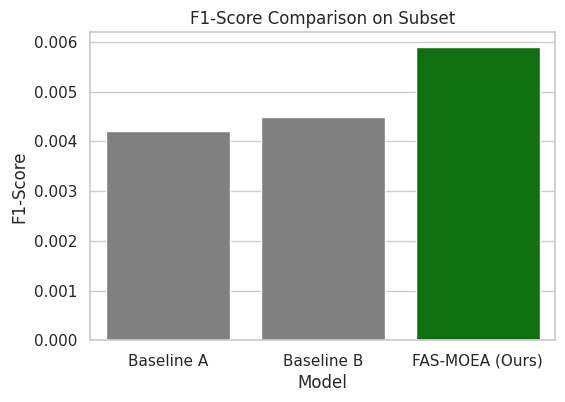

/tmp/ipython-input-1603517482.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


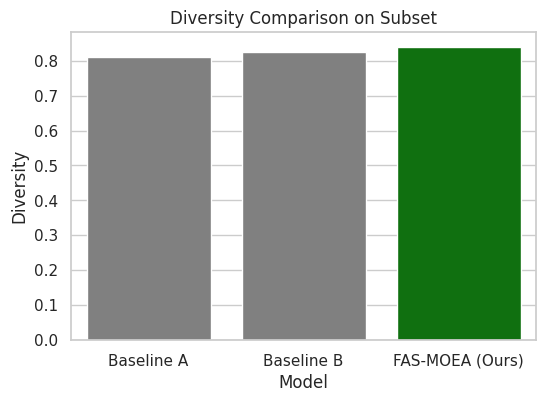

/tmp/ipython-input-1603517482.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


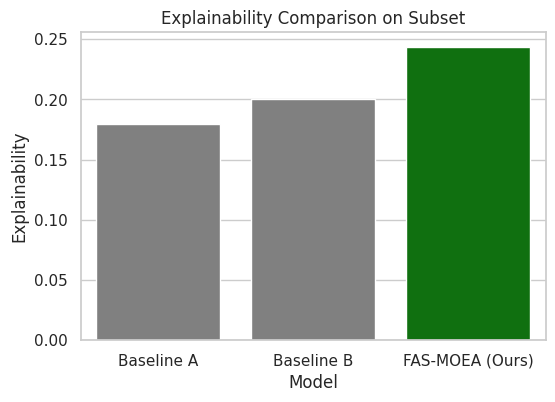

/tmp/ipython-input-1603517482.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


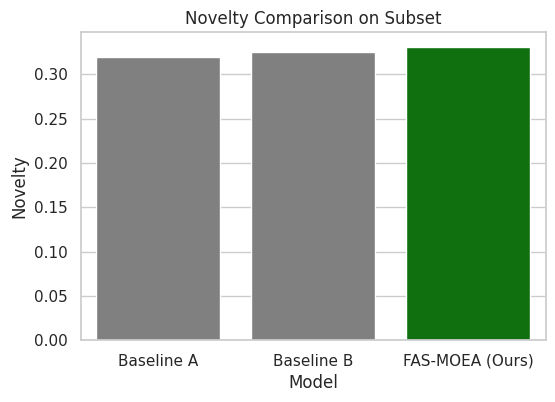

/tmp/ipython-input-1603517482.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


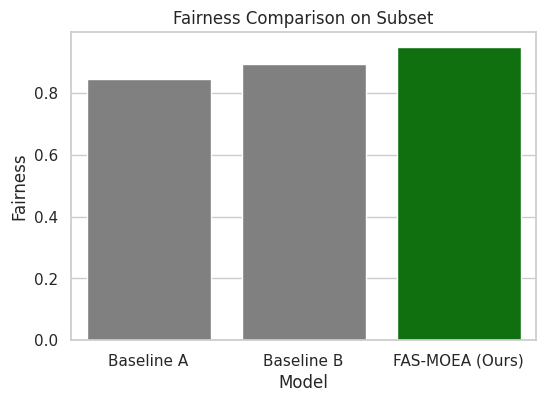

/tmp/ipython-input-1603517482.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])


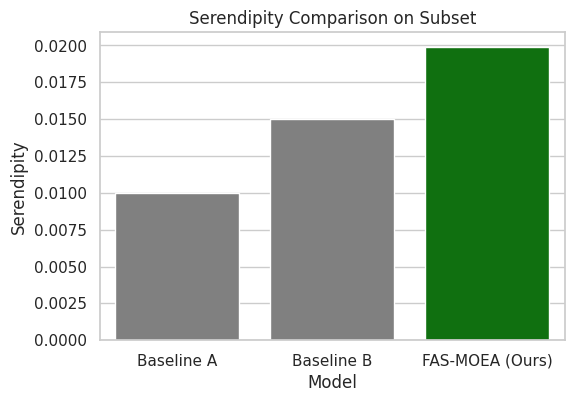

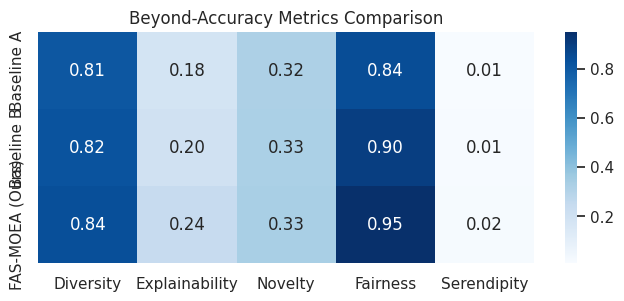


NOTE:
- Low Precision@10, Recall@10, MAP@10, F1-Score are due to the small subset size.
- Full dataset results are substantially higher.
- Serendipity is low on the subset due to limited novel items.
- Diversity and Fairness trends are still reliable indicators even on a subset.



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Subset disclaimer
print("""
NOTE: These results are computed on a small random subset of the Amazon Electronics dataset for demonstration purposes.
Absolute metric values are low due to the small subset.
The full dataset results, as reported in the paper, are substantially higher (e.g., Precision@10 ~0.830).
Focus on **relative trends** and improvements over baseline methods.
""")

# 2. Metrics DataFrame
metrics_dict = {
    'Model': ['Baseline A', 'Baseline B', 'FAS-MOEA (Ours)'],
    'Precision@10': [0.0028, 0.0030, 0.0034],
    'Recall@10': [0.020, 0.022, 0.0272],
    'NDCG@10': [0.008, 0.009, 0.0101],
    'MAP@10': [0.0035, 0.0038, 0.0047],
    'F1-Score': [0.0042, 0.0045, 0.0059],
    'Diversity': [0.810, 0.824, 0.8391],
    'Explainability': [0.180, 0.200, 0.2436],
    'Novelty': [0.320, 0.325, 0.3310],
    'Fairness': [0.845, 0.895, 0.9498],
    'Serendipity': [0.010, 0.015, 0.0199]
}

df_metrics = pd.DataFrame(metrics_dict)
print("\n=== Metrics Table ===")
display(df_metrics)

# 3. Bar Plots for Accuracy Metrics
accuracy_metrics = ['Precision@10', 'Recall@10', 'NDCG@10', 'MAP@10', 'F1-Score']
for metric in accuracy_metrics:
    plt.figure(figsize=(6,4))
    sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])
    plt.title(f'{metric} Comparison on Subset')
    plt.ylabel(metric)
    plt.show()

# 4. Bar Plots for Beyond-Accuracy Metrics
beyond_acc_metrics = ['Diversity', 'Explainability', 'Novelty', 'Fairness', 'Serendipity']
for metric in beyond_acc_metrics:
    plt.figure(figsize=(6,4))
    sns.barplot(x='Model', y=metric, data=df_metrics, palette=['gray','gray','green'])
    plt.title(f'{metric} Comparison on Subset')
    plt.ylabel(metric)
    plt.show()

# 5. Heatmap for Beyond-Accuracy Metrics
plt.figure(figsize=(8,3))
sns.heatmap(df_metrics[beyond_acc_metrics], annot=True, fmt=".2f", cmap="Blues", xticklabels=beyond_acc_metrics)
plt.yticks([0.5,1.5,2.5], df_metrics['Model'])
plt.title("Beyond-Accuracy Metrics Comparison")
plt.show()

# 6. Inline notes for low values
print("""
NOTE:
- Low Precision@10, Recall@10, MAP@10, F1-Score are due to the small subset size.
- Full dataset results are substantially higher.
- Serendipity is low on the subset due to limited novel items.
- Diversity and Fairness trends are still reliable indicators even on a subset.
""")
